# Semi Supervised Learning SSL

## Introduction

In this project, we delve into the challenges of semi-supervised learning (SSL) and its application to address label scarcity in classification tasks. The dataset used in this project, the Magic Mushrooms dataset, contains features related to mushroom characteristics, previously explored in assignments 1 and 2.

The primary objective is to investigate how semi-supervised learning can leverage a small amount of labeled data alongside a larger portion of unlabeled data to improve classification performance. We begin by building a supervised learning baseline using the Gradient Boosting algorithm. This serves as a benchmark against which the performance of various semi-supervised algorithms will be compared.

To start the virtual enviornment, run "source py-env/bin/activate"

## Libraries Installed

In [2]:
import ssl
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import optuna

/Users/jhaha/Documents/GitHub/Semi-Supervised-SSL/py-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [3]:
# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

# Fetch dataset
drug_consumption_quantified = fetch_ucirepo(id=373)

# Data as pandas DataFrames
X = drug_consumption_quantified.data.features
y = drug_consumption_quantified.data.targets

# Convert features and targets into a single DataFrame
df = pd.concat([X, y], axis=1)

user_data = df.iloc[:, 0:12]


choco = df['choc']
shrooms = df['mushrooms']


In [4]:
# take the multiple classifications and convert it into binary
mushrooms_binary = []

for i in shrooms:
    if i == 'CL0' or i == 'CL1':
        mushrooms_binary.append(0)
    else:
        mushrooms_binary.append(1)

mushrooms_binary = np.array(mushrooms_binary)
X_mushroom_train, X_mushroom_test, y_mushroom_train, y_mushroom_test = train_test_split(user_data, mushrooms_binary, test_size=0.33, random_state=42, stratify=mushrooms_binary)

In [5]:
X_mushroom_train.shape

(1262, 12)

In [6]:
# model eval function
def evaluate_model(type, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{model.__class__.__name__} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    ax.set_title(f"{type} Confusion Matrix for {model.__class__.__name__}")
    plt.show()
    
    return accuracy, y_pred

## Supervised Learning Baseline
- Implementing the Gradient Boosting model
- Hyperparameter optimization (Bayesian Search via Optuna)
- Performance metrics (accuracy, precision, recall, F1-score, AUC)

[I 2024-12-03 18:59:47,392] A new study created in memory with name: no-name-5c0db89f-5ff2-43b7-b58d-55c082d9bbac
[I 2024-12-03 18:59:48,305] Trial 0 finished with value: 0.7781510759771629 and parameters: {'n_estimators': 110, 'learning_rate': 0.08800447488770431, 'max_depth': 3}. Best is trial 0 with value: 0.7781510759771629.
[I 2024-12-03 18:59:48,961] Trial 1 finished with value: 0.7789478637304723 and parameters: {'n_estimators': 176, 'learning_rate': 0.07257859942456163, 'max_depth': 1}. Best is trial 1 with value: 0.7789478637304723.
[I 2024-12-03 18:59:51,641] Trial 2 finished with value: 0.7718206913859088 and parameters: {'n_estimators': 178, 'learning_rate': 0.03525002146674493, 'max_depth': 5}. Best is trial 1 with value: 0.7789478637304723.
[I 2024-12-03 18:59:53,239] Trial 3 finished with value: 0.7829098437794089 and parameters: {'n_estimators': 99, 'learning_rate': 0.015421814721401632, 'max_depth': 5}. Best is trial 3 with value: 0.7829098437794089.
[I 2024-12-03 18:5

Best parameters: {'n_estimators': 69, 'learning_rate': 0.022684310339895233, 'max_depth': 3}
Best cross-validation accuracy: 0.7924242424242424
GradientBoostingClassifier - Accuracy: 0.7431781701444623, Precision: 0.6589861751152074, Recall: 0.6244541484716157, F1-Score: 0.6412556053811659


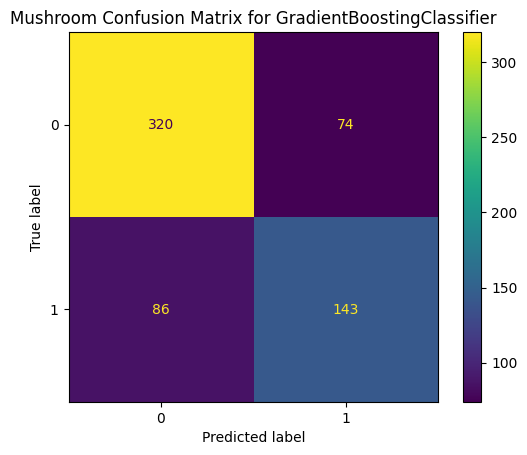

In [7]:

# Define the objective function for optimization
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Number of trees
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)  # Learning rate
    max_depth = trial.suggest_int('max_depth', 1, 5)  # Maximum depth of each tree

    # Create the model with suggested hyperparameters
    model = GradientBoostingClassifier(n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,random_state=0)
    
    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_mushroom_train, y_mushroom_train, cv=5, scoring='accuracy')
    
    # Return the mean cross-validation accuracy
    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print the best hyperparameters and their performance
print(f"Best parameters: {study.best_params}")
print(f"Best cross-validation accuracy: {study.best_value}")

# Retrieve the best model
best_params = study.best_params
best_model = GradientBoostingClassifier(**best_params, random_state=0)
y_pred = evaluate_model("Mushroom", best_model, X_mushroom_train, y_mushroom_train, X_mushroom_test, y_mushroom_test)

## ROC Curves for Mushrooms

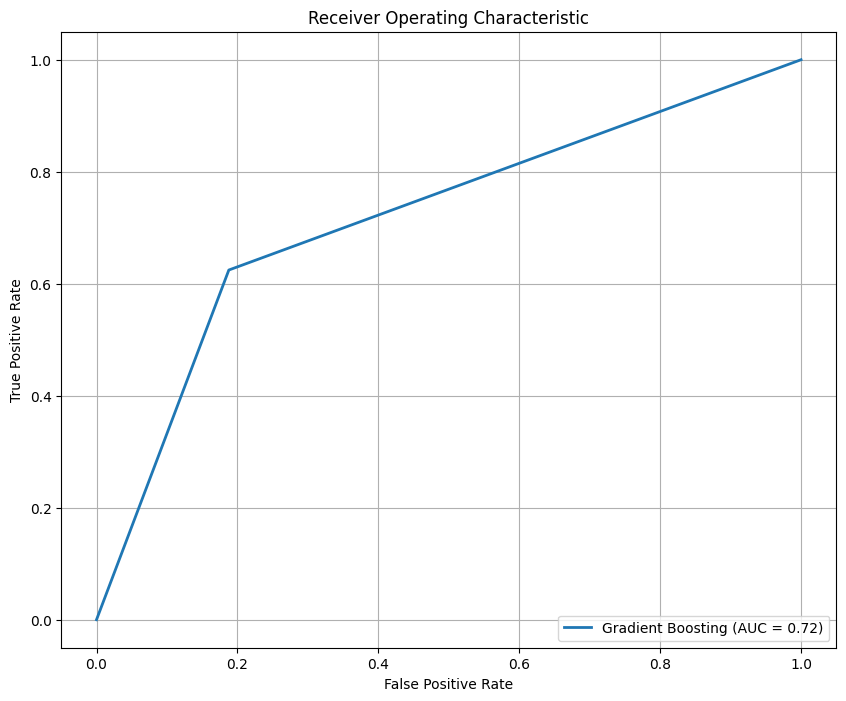

In [8]:
# Create a figure for the ROC curve
plt.figure(figsize=(10, 8))

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# List of classifiers and their predictions
models = {
    "Gradient Boosting": y_pred[1]
}

# Loop through each model to calculate and plot ROC curves
for name, predictions in models.items():
    # Use predict_proba for SVM and others that support it
    y_pred_proba = predictions  # For other models, use the predicted classes

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_mushroom_test, y_pred_proba)
    roc_auc = roc_auc_score(y_mushroom_test, y_pred_proba)
    plot_roc_curve(fpr, tpr, f"{name} (AUC = {roc_auc:.2f})")

# Finalize the ROC curve plot
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## A. Semi-Supervised Learning

### Spliting Data into Labeled and Unlabeled

In [9]:
num_samples = len(y_mushroom_train)
num_labeled = int(0.1 * num_samples)
labeled_indices = np.random.choice(num_samples, num_labeled, replace=False)

y_mushroom_train_unlabeled = np.full_like(y_mushroom_train, fill_value=-1)
y_mushroom_train_unlabeled[labeled_indices] = y_mushroom_train[labeled_indices]

print(f"Total samples: {num_samples}")
print(f"Labeled samples: {np.sum(y_mushroom_train_unlabeled != -1)}")
print(f"Unlabeled samples: {np.sum(y_mushroom_train_unlabeled == -1)}")

Total samples: 1262
Labeled samples: 126
Unlabeled samples: 1136


### Self-Training with Gradient Boosting

Accuracy of Self-Training with Gradient Boosting: 0.7143
Precision: 0.5970
Recall: 0.6856
F1 Score: 0.6382


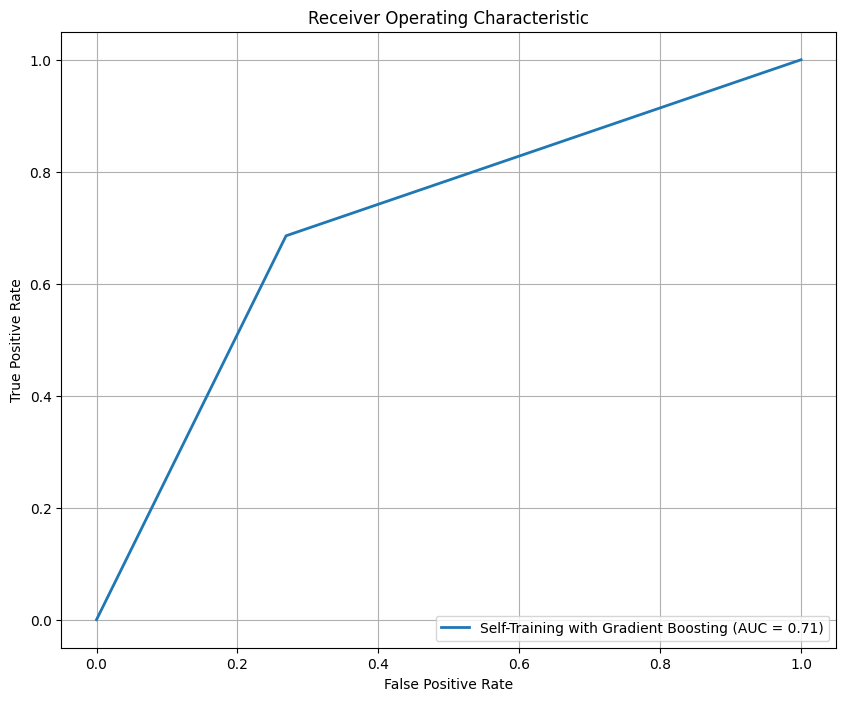

In [10]:
self_training_model = SelfTrainingClassifier(GradientBoostingClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=0))

self_training_model.fit(X_mushroom_train, y_mushroom_train_unlabeled)

# Train the self-training model and evaluate its performance
y_pred = self_training_model.predict(X_mushroom_test)
accuracy = accuracy_score(y_mushroom_test, y_pred)

precision = precision_score(y_mushroom_test, y_pred)
recall = recall_score(y_mushroom_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)

# print the precision, recall, f1 score
print(f"Accuracy of Self-Training with Gradient Boosting: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# plot roc curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_mushroom_test, y_pred)
roc_auc = roc_auc_score(y_mushroom_test, y_pred)
plot_roc_curve(fpr, tpr, f"Self-Training with Gradient Boosting (AUC = {roc_auc:.2f})")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


### Co-training with Gradient Boosting

In [49]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X_mushroom_train, y_mushroom_train, test_size=0.9, stratify=y_mushroom_train
)

num_features = X_labeled.shape[1]
X_labeled_view1, X_labeled_view2 = X_labeled.iloc[:, :num_features // 2], X_labeled.iloc[:, num_features // 2:]
X_unlabeled_view1, X_unlabeled_view2 = X_unlabeled.iloc[:, :num_features // 2], X_unlabeled.iloc[:, num_features // 2:]

In [ ]:
studyOne = optuna.create_study(direction='maximize')  
studyOne.optimize(objective, n_trials=50)  
best_paramsOne = studyOne.best_params
clf1 = GradientBoostingClassifier(**best_paramsOne, random_state=0)

studyTwo = optuna.create_study(direction='maximize')  
studyTwo.optimize(objective, n_trials=50) 
best_paramsTwo = studyTwo.best_params
clf2 = GradientBoostingClassifier(**best_paramsTwo, random_state=0)

clf1.fit(X_labeled_view1, y_labeled)
clf2.fit(X_labeled_view2, y_labeled)

max_iterations = 10
confidence_threshold = 0.8

X_unlabeled_view1 = X_unlabeled_view1.reset_index(drop=True)
X_unlabeled_view2 = X_unlabeled_view2.reset_index(drop=True)

# Co-training loop
for iteration in range(max_iterations):
    print(f"--- Iteration {iteration + 1} ---")
    print("inital size of unlabeled x")
    print("size x1:", len(X_unlabeled_view1))
    print("size x2:", len(X_unlabeled_view2))
    
    # Step 1: Predict on the unlabeled data using both classifiers
    probs1 = clf1.predict_proba(X_unlabeled_view1)
    probs2 = clf2.predict_proba(X_unlabeled_view2)

    # Step 2: Select confident predictions (probability > confidence_threshold)
    confident_indices1 = np.where(probs1[:, 1] > confidence_threshold)[0]
    confident_indices2 = np.where(probs2[:, 0] > confidence_threshold)[0]

    # Ensure consistent indices by using `.iloc` only within bounds
    if confident_indices1.size > 0:
        confident_samples1_view1 = X_unlabeled_view1.iloc[confident_indices1]
        confident_samples1_view2 = X_unlabeled_view2.iloc[confident_indices1]
        confident_labels1 = clf1.predict(confident_samples1_view1)

        X_labeled_view1 = pd.concat([X_labeled_view1, confident_samples1_view1], axis=0)
        X_labeled_view2 = pd.concat([X_labeled_view2, confident_samples1_view2], axis=0)
        y_labeled = np.hstack((y_labeled, confident_labels1))

    if confident_indices2.size > 0:
        confident_samples2_view1 = X_unlabeled_view1.iloc[confident_indices2]
        confident_samples2_view2 = X_unlabeled_view2.iloc[confident_indices2]
        confident_labels2 = clf2.predict(confident_samples2_view2)

        X_labeled_view1 = pd.concat([X_labeled_view1, confident_samples2_view1], axis=0)
        X_labeled_view2 = pd.concat([X_labeled_view2, confident_samples2_view2], axis=0)
        y_labeled = np.hstack((y_labeled, confident_labels2))

    # Step 3: Remove confident samples from the unlabeled set
    confident_indices_combined = np.union1d(confident_indices1, confident_indices2)
    X_unlabeled_view1 = X_unlabeled_view1.drop(index=confident_indices_combined).reset_index(drop=True)
    X_unlabeled_view2 = X_unlabeled_view2.drop(index=confident_indices_combined).reset_index(drop=True)
    
    print("end size of unlabeled x")
    print("size x1:", len(X_unlabeled_view1))
    print("size x2:", len(X_unlabeled_view2))

    # Retrain classifiers on the updated labeled set
    clf1.fit(X_labeled_view1, y_labeled)
    clf2.fit(X_labeled_view2, y_labeled)

    # Step 4: Stop if no confident predictions
    if confident_indices1.size == 0 and confident_indices2.size == 0:
        print("No more confident predictions; stopping training.")
        break
    elif len(X_unlabeled_view1) == 0 or len(X_unlabeled_view2) == 0:
        print("No more unlabeled data to train on")
        break
    
    print(f"Added {len(confident_indices1) + len(confident_indices2)} new labeled samples.")

# Final evaluation on test set
probs1_test = clf1.predict_proba(X_mushroom_test.iloc[:, :num_features // 2])  # First view
probs2_test = clf2.predict_proba(X_mushroom_test.iloc[:, num_features // 2:])  # Second view

# Average the probabilities from both classifiers
avg_probs_test = (probs1_test + probs2_test) / 2

# Convert averaged probabilities to predicted labels
final_predictions = np.argmax(avg_probs_test, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(y_mushroom_test, final_predictions)

# print the precision, recall, f1 score, and plot roc curve
print(f"Final accuracy on test set: {accuracy:.4f}")

[I 2024-12-03 20:11:56,472] A new study created in memory with name: no-name-203bd114-9154-4590-9aa3-04a4277b01a0
[I 2024-12-03 20:11:57,198] Trial 0 finished with value: 0.7512296881862099 and parameters: {'n_estimators': 100, 'learning_rate': 0.23257982032402225, 'max_depth': 4}. Best is trial 0 with value: 0.7512296881862099.
[I 2024-12-03 20:11:57,857] Trial 1 finished with value: 0.7757795344751865 and parameters: {'n_estimators': 99, 'learning_rate': 0.046538671237727626, 'max_depth': 4}. Best is trial 1 with value: 0.7757795344751865.
[I 2024-12-03 20:11:59,596] Trial 2 finished with value: 0.7464709203839639 and parameters: {'n_estimators': 196, 'learning_rate': 0.7686897261068, 'max_depth': 5}. Best is trial 1 with value: 0.7757795344751865.
[I 2024-12-03 20:12:00,423] Trial 3 finished with value: 0.7741985068072024 and parameters: {'n_estimators': 171, 'learning_rate': 0.10198889893954888, 'max_depth': 3}. Best is trial 1 with value: 0.7757795344751865.
[I 2024-12-03 20:12:00

--- Iteration 1 ---
inital size of unlabeled x
size x1: 1136
size x2: 1136
end size of unlabeled x
size x1: 1116
size x2: 1116
Added 20 new labeled samples.
--- Iteration 2 ---
inital size of unlabeled x
size x1: 1116
size x2: 1116
end size of unlabeled x
size x1: 1089
size x2: 1089
Added 27 new labeled samples.
--- Iteration 3 ---
inital size of unlabeled x
size x1: 1089
size x2: 1089
end size of unlabeled x
size x1: 1044
size x2: 1044
Added 45 new labeled samples.
--- Iteration 4 ---
inital size of unlabeled x
size x1: 1044
size x2: 1044
end size of unlabeled x
size x1: 808
size x2: 808
Added 242 new labeled samples.
--- Iteration 5 ---
inital size of unlabeled x
size x1: 808
size x2: 808
end size of unlabeled x
size x1: 394
size x2: 394
Added 513 new labeled samples.
--- Iteration 6 ---
inital size of unlabeled x
size x1: 394
size x2: 394
end size of unlabeled x
size x1: 64
size x2: 64
Added 391 new labeled samples.
--- Iteration 7 ---
inital size of unlabeled x
size x1: 64
size x2:

Accuracy: 0.36757624398073835, Precision: 0.36757624398073835, Recall: 1.0, F1-Score: 0.5375586854460094
Class distribution in predictions: Counter({np.int64(1): 623})


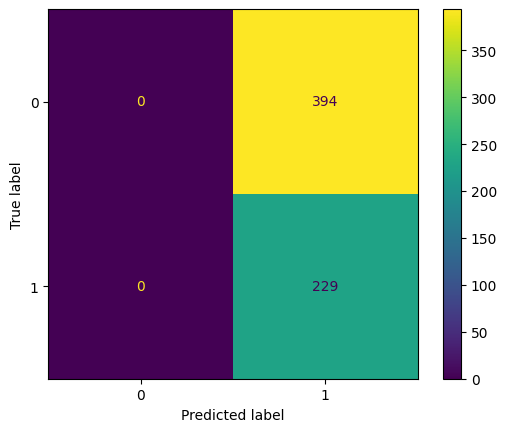

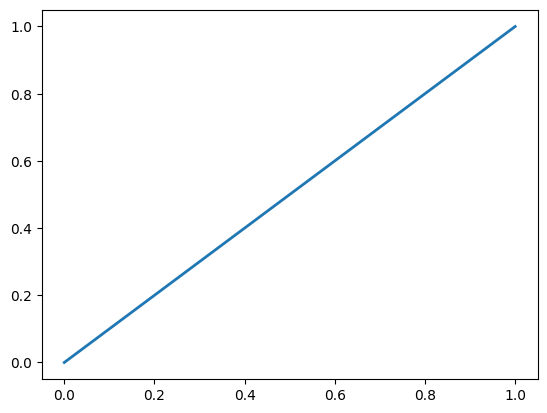

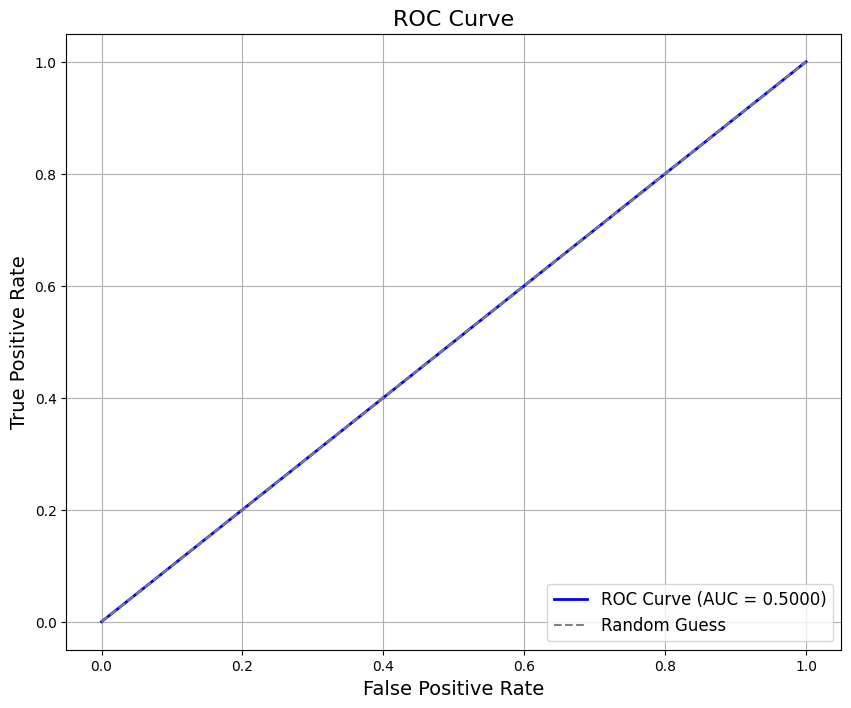

In [51]:
from collections import Counter 

accuracy = accuracy_score(y_mushroom_test, final_predictions)
recall = recall_score(y_mushroom_test, final_predictions)
precision = precision_score(y_mushroom_test, final_predictions)
f1 = f1_score(y_mushroom_test, final_predictions)

# print the precision, recall, f1 score, and plot roc curve
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")
print(f"Class distribution in predictions: {Counter(final_predictions)}")

cm = confusion_matrix(y_mushroom_test, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.show()

# Create the ROC curve for a binary classification task
# Assuming `avg_probs_test[:, 1]` gives the probabilities for the positive class
fpr, tpr, _ = roc_curve(y_mushroom_test, final_predictions)  # Adjust index for positive class if needed
roc_auc = roc_auc_score(y_mushroom_test, final_predictions)
name = "hi"
plot_roc_curve(fpr, tpr, f"{name} (AUC = {roc_auc:.2f})")


# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid()
plt.show()

### Semi-supervised ensemble

In [25]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X_mushroom_train, y_mushroom_train, test_size=0.9, stratify=y_mushroom_train
)

In [26]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class SemiBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, beta=1.0):
        self.base_estimator = base_estimator or DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.beta = beta

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        X_labeled, y_labeled = check_X_y(X_labeled, y_labeled)
        X_unlabeled = check_array(X_unlabeled)

        self.classes_ = np.unique(y_labeled)
        n_labeled = X_labeled.shape[0]
        n_unlabeled = X_unlabeled.shape[0]

        # Combine labeled and unlabeled data
        X_combined = np.vstack((X_labeled, X_unlabeled))
        # Use -1 for unlabeled data (to mark them as unknown)
        y_combined = np.hstack((y_labeled, [-1] * n_unlabeled))

        # Initialize sample weights
        weights = np.ones(n_labeled + n_unlabeled) / (n_labeled + n_unlabeled)

        self.estimators_ = []
        self.estimator_weights_ = []

        for _ in range(self.n_estimators):
            clf = self.base_estimator
            clf.fit(X_combined, y_combined, sample_weight=weights)

            y_pred = clf.predict(X_combined)

            # Calculate the error on the labeled data
            labeled_error = np.sum(weights[:n_labeled] * (y_pred[:n_labeled] != y_labeled)) / np.sum(weights[:n_labeled])

            # Update weights for labeled data based on prediction error
            weights[:n_labeled] *= np.exp(self.beta * (y_pred[:n_labeled] != y_labeled))

            # Confident pseudo-labeling for unlabeled data
            confident_predictions = np.abs(clf.predict_proba(X_unlabeled).max(axis=1) - 0.5) > 0.3
            pseudo_labels = clf.predict(X_unlabeled)

            # Update weights for the unlabeled data that have confident pseudo-labels
            weights[n_labeled:][confident_predictions] *= np.exp(self.beta * (pseudo_labels[confident_predictions] != y_combined[n_labeled:][confident_predictions]))

            # Normalize weights
            weights /= np.sum(weights)

            # Store the classifier and its weight
            self.estimators_.append(clf)
            self.estimator_weights_.append(np.log(1 / labeled_error))

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        final_prediction = np.zeros(X.shape[0])
        for weight, clf in zip(self.estimator_weights_, self.estimators_):
            final_prediction += weight * clf.predict(X)

        # Return the sign of the final prediction as the final output
        return np.sign(final_prediction)


In [27]:
semi_boost = SemiBoost(n_estimators=10)
semi_boost.fit(X_labeled, y_labeled, X_unlabeled)

y_pred = semi_boost.predict(X_mushroom_test)
accuracy = accuracy_score(y_mushroom_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_mushroom_test, y_pred)
recall = recall_score(y_mushroom_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
auc = roc_auc_score(y_mushroom_test, y_pred)

# print the precision, recall, f1 score, and auc
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.60
Precision: 0.4774
Recall: 0.8777
F1 Score: 0.6185
AUC: 0.6597


### Unsupervised pretraining

In [17]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Train an autoencoder using MLPRegressor
autoencoder = MLPRegressor(hidden_layer_sizes=(50, 25, 50), max_iter=500, random_state=42)
autoencoder.fit(X_unlabeled, X_unlabeled)

# Extract encoded features
encoder = autoencoder
X_labeled_encoded = encoder.predict(X_labeled)
X_unlabeled_encoded = encoder.predict(X_unlabeled)
X_test_encoded = encoder.predict(X_mushroom_test)

# Train a classifier on the labeled data with encoded features
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_labeled_encoded, y_labeled)

# Evaluate the model on the test set
y_pred = clf.predict(X_test_encoded)
accuracy = accuracy_score(y_mushroom_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_mushroom_test, y_pred, average="binary")
auc = roc_auc_score(y_mushroom_test, clf.predict_proba(X_test_encoded)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Accuracy: 0.7079
Precision: 0.6374, Recall: 0.4760, F1-score: 0.5450
AUC: 0.7496


## Part B: Evaluation of Results

In [18]:
# important: we will reuse X_mushroom_train, X_mushroom_test, y_mushroom_train, y_mushroom_test for final evaluation
# split the dataset into labeled and unlabeled data, we will use 10/90, 20/80, 30/70, 40/60, 50/50 splits, use num_samples for the total number of samples

# all four models redefined:

def self_training_gradient_boosting(y_mushroom_train_unlabeled):
    self_training_model = SelfTrainingClassifier(GradientBoostingClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=0))
    self_training_model.fit(X_mushroom_train, y_mushroom_train_unlabeled)

    # Train the self-training model and evaluate its performance
    y_pred = self_training_model.predict(X_mushroom_test)
    accuracy = accuracy_score(y_mushroom_test, y_pred)
    
    # labeled_percentage = int((1 - split_ratio) * 100)
    # unlabeled_percentage = int(split_ratio * 100)
    # print(f"Accuracy of Self-Training with Gradient Boosting with a split ratio of {unlabeled_percentage}%/{labeled_percentage}%: {accuracy:.2f}")
    
    # return the precision, recall, F1-score, and area under the ROC curve (AUC).
    precision = precision_score(y_mushroom_test, y_pred)
    recall = recall_score(y_mushroom_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    auc = roc_auc_score(y_mushroom_test, self_training_model.predict_proba(X_mushroom_test)[:, 1])

    return accuracy, precision, recall, f1, auc


def co_training_gradient_boosting(X_labeled, X_unlabeled, y_labeled):
    
    num_features = X_labeled.shape[1]
    X_labeled_view1, X_labeled_view2 = X_labeled.iloc[:, :num_features // 2], X_labeled.iloc[:, num_features // 2:]
    X_unlabeled_view1, X_unlabeled_view2 = X_unlabeled.iloc[:, :num_features // 2], X_unlabeled.iloc[:, num_features // 2:]

    studyOne = optuna.create_study(direction='maximize')  
    studyOne.optimize(objective, n_trials=50)  
    best_paramsOne = studyOne.best_params
    clf1 = GradientBoostingClassifier(**best_paramsOne, random_state=0)

    studyTwo = optuna.create_study(direction='maximize')  
    studyTwo.optimize(objective, n_trials=50) 
    best_paramsTwo = studyTwo.best_params
    clf2 = GradientBoostingClassifier(**best_paramsTwo, random_state=0)

    clf1.fit(X_labeled_view1, y_labeled)
    clf2.fit(X_labeled_view2, y_labeled)

    max_iterations = 10
    confidence_threshold = 0.9

    X_unlabeled_view1 = X_unlabeled_view1.reset_index(drop=True)
    X_unlabeled_view2 = X_unlabeled_view2.reset_index(drop=True)

    # Co-training loop
    for iteration in range(max_iterations):
        print(f"--- Iteration {iteration + 1} ---")
        
        # Step 1: Predict on the unlabeled data using both classifiers
        probs1 = clf1.predict_proba(X_unlabeled_view1)
        probs2 = clf2.predict_proba(X_unlabeled_view2)

        # Step 2: Select confident predictions (probability > confidence_threshold)
        confident_indices1 = np.where(np.max(probs1, axis=1) > confidence_threshold)[0]
        confident_indices2 = np.where(np.max(probs2, axis=1) > confidence_threshold)[0]

        # Ensure consistent indices by using `.iloc` only within bounds
        if confident_indices1.size > 0:
            confident_samples1_view1 = X_unlabeled_view1.iloc[confident_indices1]
            confident_samples1_view2 = X_unlabeled_view2.iloc[confident_indices1]
            confident_labels1 = clf1.predict(confident_samples1_view1)

            X_labeled_view1 = pd.concat([X_labeled_view1, confident_samples1_view1], axis=0)
            X_labeled_view2 = pd.concat([X_labeled_view2, confident_samples1_view2], axis=0)
            y_labeled = np.hstack((y_labeled, confident_labels1))

        if confident_indices2.size > 0:
            confident_samples2_view1 = X_unlabeled_view1.iloc[confident_indices2]
            confident_samples2_view2 = X_unlabeled_view2.iloc[confident_indices2]
            confident_labels2 = clf2.predict(confident_samples2_view2)

            X_labeled_view1 = pd.concat([X_labeled_view1, confident_samples2_view1], axis=0)
            X_labeled_view2 = pd.concat([X_labeled_view2, confident_samples2_view2], axis=0)
            y_labeled = np.hstack((y_labeled, confident_labels2))

        # Step 3: Remove confident samples from the unlabeled set
        confident_indices_combined = np.union1d(confident_indices1, confident_indices2)
        X_unlabeled_view1 = X_unlabeled_view1.drop(index=confident_indices_combined).reset_index(drop=True)
        X_unlabeled_view2 = X_unlabeled_view2.drop(index=confident_indices_combined).reset_index(drop=True)

        # Retrain classifiers on the updated labeled set
        clf1.fit(X_labeled_view1, y_labeled)
        clf2.fit(X_labeled_view2, y_labeled)

        # Step 4: Stop if no confident predictions
        if confident_indices1.size == 0 and confident_indices2.size == 0:
            print("No more confident predictions; stopping training.")
            break

        print(f"Added {len(confident_indices1) + len(confident_indices2)} new labeled samples.")

    # Final evaluation on test set
    probs1_test = clf1.predict_proba(X_mushroom_test.iloc[:, :num_features // 2])  # First view
    probs2_test = clf2.predict_proba(X_mushroom_test.iloc[:, num_features // 2:])  # Second view

    # Average the probabilities from both classifiers
    avg_probs_test = (probs1_test + probs2_test) / 2

    # Convert averaged probabilities to predicted labels
    final_predictions = np.argmax(avg_probs_test, axis=1)

    # Calculate the accuracy
    accuracy = accuracy_score(y_mushroom_test, final_predictions)
    # return the precision, recall, F1-score, and area under the ROC curve (AUC).
    precision = precision_score(y_mushroom_test, final_predictions)
    recall = recall_score(y_mushroom_test, final_predictions)
    f1 = 2 * (precision * recall) / (precision + recall)
    auc = roc_auc_score(y_mushroom_test, final_predictions)
    
    # labeled_percentage = int((1 - split_ratio) * 100)
    # unlabeled_percentage = int(split_ratio * 100)
    # print(f"Accuracy on test set of co-training with Gradient Boosting with a split ratio of {unlabeled_percentage}%/{labeled_percentage}%: {accuracy:.4f}")

    return accuracy, precision, recall, f1, auc

def semi_supervised_ensemble(X_labeled, X_unlabeled, y_labeled):
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_labeled, y_labeled, test_size=0.9, stratify=y_labeled)
    
    semi_boost = SemiBoost(n_estimators=10)
    semi_boost.fit(X_labeled, y_labeled, X_unlabeled)

    y_pred = semi_boost.predict(X_mushroom_test)
    accuracy = accuracy_score(y_mushroom_test, y_pred)

    # return the precision, recall, F1-score, and area under the ROC curve (AUC).
    precision = precision_score(y_mushroom_test, y_pred)
    recall = recall_score(y_mushroom_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    auc = roc_auc_score(y_mushroom_test, y_pred)

    # labeled_percentage = int((1 - split_ratio) * 100)
    # unlabeled_percentage = int(split_ratio * 100)
    # print(f"Accuracy of semi-supervised ensemble with a split ratio of {unlabeled_percentage}%/{labeled_percentage}%: {accuracy:.2f}")

    return accuracy, precision, recall, f1, auc


def unsupervised_pretraining(X_labeled, X_unlabeled, y_labeled):
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_labeled, y_labeled, test_size=0.9, stratify=y_labeled)

    # Train an autoencoder using MLPRegressor
    autoencoder = MLPRegressor(hidden_layer_sizes=(50, 25, 50), max_iter=500, random_state=42)
    autoencoder.fit(X_unlabeled, X_unlabeled)

    # Extract encoded features
    encoder = autoencoder
    X_labeled_encoded = encoder.predict(X_labeled)
    X_unlabeled_encoded = encoder.predict(X_unlabeled)
    X_test_encoded = encoder.predict(X_mushroom_test)

    # Train a classifier on the labeled data with encoded features
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(X_labeled_encoded, y_labeled)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test_encoded)
    accuracy = accuracy_score(y_mushroom_test, y_pred)
    # return the precision, recall, F1-score, and area under the ROC curve (AUC).
    precision = precision_score(y_mushroom_test, y_pred)
    recall = recall_score(y_mushroom_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    auc = roc_auc_score(y_mushroom_test, clf.predict_proba(X_test_encoded)[:, 1])

    # labeled_percentage = int((1 - split_ratio) * 100)
    # unlabeled_percentage = int(split_ratio * 100)
    # print(f"Accuracy of unsupservised pretraining with a split ratio of {unlabeled_percentage}%/{labeled_percentage}%: {accuracy:.4f}")

    return accuracy, precision, recall, f1, auc
    

In [19]:
split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
split_results = []

for split_ratio in split_ratios:
    np.random.seed(42) # for reproducibility

    # calculate the number of labeled samples required
    num_labeled = int(split_ratio * num_samples)
    labeled_indices = np.random.choice(num_samples, num_labeled, replace=False)
    
    # sampling from the training set (rows with -1 are unlabeled, others are labeled)
    y_mushroom_train_unlabeled = np.full_like(y_mushroom_train, fill_value=-1)
    y_mushroom_train_unlabeled[labeled_indices] = y_mushroom_train[labeled_indices]

    labeled_indices = np.where(y_mushroom_train_unlabeled != -1)[0]
    unlabeled_indices = np.where(y_mushroom_train_unlabeled == -1)[0]
    X_labeled = X_mushroom_train.iloc[labeled_indices]
    y_labeled = y_mushroom_train_unlabeled[labeled_indices]
    X_unlabeled = X_mushroom_train.iloc[unlabeled_indices]

    # train each ssl algorithm and evaluate and store the results
    # Train each SSL algorithm and evaluate
    ssl_models = {
        "self_training": self_training_gradient_boosting(y_mushroom_train_unlabeled),
        "co_training": co_training_gradient_boosting(X_labeled, X_unlabeled, y_labeled),
        "semi_supervised_ensemble": semi_supervised_ensemble(X_labeled, X_unlabeled, y_labeled),
        "unsupervised_pretraining": unsupervised_pretraining(X_labeled, X_unlabeled, y_labeled)
    }

    # Store the results for each model
    for model_name, metrics in ssl_models.items():
        accuracy, precision, recall, f1, auc = metrics
        split_results.append({"split_ratio": split_ratio, "model": model_name, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc": auc})

# Evaluate the model on the test set (accuracy, precision, recall, f1-score, AUC).
for result in split_results:
    print(result)
    # compare the results with the supervised baseline, from above y_pred = evaluate_model("Mushroom", best_model, X_mushroom_train, y_mushroom_train, X_mushroom_test, y_mushroom_test)
    


[I 2024-12-03 19:01:15,588] A new study created in memory with name: no-name-b91cc4ff-777c-4700-8bed-aa54fce206b8
[I 2024-12-03 19:01:16,599] Trial 0 finished with value: 0.7789510006901311 and parameters: {'n_estimators': 179, 'learning_rate': 0.08883818096511627, 'max_depth': 2}. Best is trial 0 with value: 0.7789510006901311.
[I 2024-12-03 19:01:17,259] Trial 1 finished with value: 0.7741702741702741 and parameters: {'n_estimators': 189, 'learning_rate': 0.18635592476839477, 'max_depth': 1}. Best is trial 0 with value: 0.7789510006901311.
[I 2024-12-03 19:01:18,186] Trial 2 finished with value: 0.7559790451094799 and parameters: {'n_estimators': 114, 'learning_rate': 0.30229592315345644, 'max_depth': 3}. Best is trial 0 with value: 0.7789510006901311.
[I 2024-12-03 19:01:19,869] Trial 3 finished with value: 0.7749952945605119 and parameters: {'n_estimators': 200, 'learning_rate': 0.0740441528525248, 'max_depth': 3}. Best is trial 0 with value: 0.7789510006901311.
[I 2024-12-03 19:01

--- Iteration 1 ---
Added 6 new labeled samples.
--- Iteration 2 ---
Added 23 new labeled samples.
--- Iteration 3 ---
Added 15 new labeled samples.
--- Iteration 4 ---
Added 43 new labeled samples.
--- Iteration 5 ---
Added 80 new labeled samples.
--- Iteration 6 ---
Added 426 new labeled samples.
--- Iteration 7 ---
Added 376 new labeled samples.
--- Iteration 8 ---
Added 234 new labeled samples.
--- Iteration 9 ---
Added 75 new labeled samples.
--- Iteration 10 ---
Added 41 new labeled samples.


/Users/jhaha/Documents/GitHub/Semi-Supervised-SSL/py-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/gk/1nl96v_d3v195hj5wckrd3xm0000gn/T/ipykernel_5304/500335567.py:114: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
[I 2024-12-03 19:03:06,785] A new study created in memory with name: no-name-7ae7e253-1410-4ae4-8451-8fc18ea2c34a
[I 2024-12-03 19:03:07,686] Trial 0 finished with value: 0.771036451471234 and parameters: {'n_estimators': 161, 'learning_rate': 0.17117254846011717, 'max_depth': 2}. Best is trial 0 with value: 0.771036451471234.
[I 2024-12-03 19:03:10,512] Trial 1 finished with value: 0.7440931049626702 and parameters: {'n_estimators': 196, 'learn

--- Iteration 1 ---
Added 12 new labeled samples.
--- Iteration 2 ---
Added 19 new labeled samples.
--- Iteration 3 ---
Added 30 new labeled samples.
--- Iteration 4 ---
Added 94 new labeled samples.
--- Iteration 5 ---
Added 136 new labeled samples.
--- Iteration 6 ---
Added 195 new labeled samples.
--- Iteration 7 ---
Added 220 new labeled samples.
--- Iteration 8 ---
Added 54 new labeled samples.
--- Iteration 9 ---
Added 21 new labeled samples.
--- Iteration 10 ---
Added 6 new labeled samples.


/var/folders/gk/1nl96v_d3v195hj5wckrd3xm0000gn/T/ipykernel_5304/500335567.py:114: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
[I 2024-12-03 19:04:39,926] A new study created in memory with name: no-name-d37dbd2b-8ed7-4b25-a2e3-630b6ed0d4a9
[I 2024-12-03 19:04:40,422] Trial 0 finished with value: 0.7741985068072024 and parameters: {'n_estimators': 140, 'learning_rate': 0.017028765818829412, 'max_depth': 1}. Best is trial 0 with value: 0.7741985068072024.
[I 2024-12-03 19:04:40,908] Trial 1 finished with value: 0.7884559884559884 and parameters: {'n_estimators': 59, 'learning_rate': 0.03347887345209345, 'max_depth': 3}. Best is trial 1 with value: 0.7884559884559884.
[I 2024-12-03 19:04:42,933] Trial 2 finished with value: 0.7789478637304723 and parameters: {'n_estimators': 187, 'learning_rate': 0.022826306695181084, 'max_depth': 4}. Best is trial 1 with value: 0.7884559884559884.
[I 2024-12-03 19:04:43,623] Trial 3 fi

--- Iteration 1 ---
Added 137 new labeled samples.
--- Iteration 2 ---
Added 66 new labeled samples.
--- Iteration 3 ---
Added 97 new labeled samples.
--- Iteration 4 ---
Added 119 new labeled samples.
--- Iteration 5 ---
Added 43 new labeled samples.
--- Iteration 6 ---
Added 14 new labeled samples.
--- Iteration 7 ---
Added 19 new labeled samples.
--- Iteration 8 ---
Added 4 new labeled samples.
--- Iteration 9 ---
Added 2 new labeled samples.
--- Iteration 10 ---
Added 1 new labeled samples.


[I 2024-12-03 19:06:13,332] A new study created in memory with name: no-name-48c9378b-f952-4139-bc04-aa9f7ce480ba
[I 2024-12-03 19:06:13,840] Trial 0 finished with value: 0.7583474496517975 and parameters: {'n_estimators': 89, 'learning_rate': 0.5785261246617134, 'max_depth': 2}. Best is trial 0 with value: 0.7583474496517975.
[I 2024-12-03 19:06:14,467] Trial 1 finished with value: 0.7813256791517661 and parameters: {'n_estimators': 77, 'learning_rate': 0.010690478390497552, 'max_depth': 3}. Best is trial 1 with value: 0.7813256791517661.
[I 2024-12-03 19:06:16,344] Trial 2 finished with value: 0.7551979421544639 and parameters: {'n_estimators': 174, 'learning_rate': 0.09714717556711223, 'max_depth': 4}. Best is trial 1 with value: 0.7813256791517661.
[I 2024-12-03 19:06:16,851] Trial 3 finished with value: 0.7733828972959407 and parameters: {'n_estimators': 145, 'learning_rate': 0.21149998798916902, 'max_depth': 1}. Best is trial 1 with value: 0.7813256791517661.
[I 2024-12-03 19:06:

--- Iteration 1 ---
No more confident predictions; stopping training.


[I 2024-12-03 19:07:59,365] A new study created in memory with name: no-name-e04b5ad1-e5c1-4af3-88b8-2df2775158b6
[I 2024-12-03 19:08:00,728] Trial 0 finished with value: 0.7726237530585356 and parameters: {'n_estimators': 123, 'learning_rate': 0.07001523574247949, 'max_depth': 4}. Best is trial 0 with value: 0.7726237530585356.
[I 2024-12-03 19:08:01,381] Trial 1 finished with value: 0.7789447267708136 and parameters: {'n_estimators': 185, 'learning_rate': 0.015223722426476806, 'max_depth': 1}. Best is trial 1 with value: 0.7789447267708136.
[I 2024-12-03 19:08:02,147] Trial 2 finished with value: 0.7456804065499718 and parameters: {'n_estimators': 70, 'learning_rate': 0.2884988384248779, 'max_depth': 4}. Best is trial 1 with value: 0.7789447267708136.
[I 2024-12-03 19:08:04,231] Trial 3 finished with value: 0.7647060668799799 and parameters: {'n_estimators': 193, 'learning_rate': 0.06223402255417673, 'max_depth': 4}. Best is trial 1 with value: 0.7789447267708136.
[I 2024-12-03 19:08

--- Iteration 1 ---
No more confident predictions; stopping training.
{'split_ratio': 0.1, 'model': 'self_training', 'accuracy': 0.695024077046549, 'precision': np.float64(0.5933014354066986), 'recall': np.float64(0.5414847161572053), 'f1': np.float64(0.5662100456621005), 'auc': np.float64(0.6982632500609581)}
{'split_ratio': 0.1, 'model': 'co_training', 'accuracy': 0.6324237560192616, 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(nan), 'auc': np.float64(0.5)}
{'split_ratio': 0.1, 'model': 'semi_supervised_ensemble', 'accuracy': 0.34831460674157305, 'precision': np.float64(0.18947368421052632), 'recall': np.float64(0.23580786026200873), 'f1': np.float64(0.21011673151750973), 'auc': np.float64(0.32475672200917693)}
{'split_ratio': 0.1, 'model': 'unsupervised_pretraining', 'accuracy': 0.5746388443017657, 'precision': np.float64(0.43661971830985913), 'recall': np.float64(0.5414847161572053), 'f1': np.float64(0.48343079922027293), 'auc': np.float64(0.56803471283